## Clusterização

Neste notebook, aplica-se do algoritmo Dinamic Time Warping (DTW), para fazer uma clusterização de usuários baseado na distribuição de atividades deles ao longo dos dias. Foi utilizado o arquivo *anonimized_logs.csv* para obtenção desses resultados




In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
logData = pd.read_csv("/content/drive/My Drive/Dados_Alura/anonimized_logs.csv") 

In [ ]:
def getDateDiff(date1, date2):
  date1_parsed = date1.split('-')
  date2_parsed = date2.split('-')
  date1_obj = datetime.datetime(int(date1_parsed[0]), int(date1_parsed[1]),int(date1_parsed[2]))
  date2_obj = datetime.datetime(int(date2_parsed[0]), int(date2_parsed[1]), int(date2_parsed[2]))
  return((date2_obj-date1_obj).days)

In [ ]:
def basicStatistic(data):
  st = np.array([data.max(), data.min(), data.mean(), np.median(data), np.std(data)])
  sr = pd.Series(st, index =["max","min","média","mediano","des. pad."])
  print(sr) 

In [ ]:
def dist_diarias(logData_user):

  logData_user.head()

  atividades = logData_user['moment'].value_counts()


  atividades = atividades.rename_axis('moment').reset_index(name='counts')

  atividades = atividades.sort_values(by = 'moment')

  atividades = atividades.reset_index(drop = True)

  datas = atividades['moment'].values



  dias = getDateDiff(datas[0],datas[datas.shape[0]-1])+1


  intervalo = np.zeros(dias)

  intervalo[0] = atividades.at[0,'counts']
  diaAtual = 0

  for i in range(len(atividades.index) - 1):
  
    dif_dia = getDateDiff(atividades.at[i,'moment'],atividades.at[i+1,'moment'])
    intervalo[dif_dia + diaAtual] = atividades.at[i,'counts']
    diaAtual = dif_dia + diaAtual

  return intervalo

In [ ]:
 uniqueUserLogCount = logData.user_uuid.value_counts()

In [ ]:
size = uniqueUserLogCount.values[uniqueUserLogCount.values>500].shape[0]


users =  uniqueUserLogCount.index[:size]

log_density = np.zeros((size))
daily_log_density = np.zeros((size))
interval = np.zeros((size))
log_counts = uniqueUserLogCount.values[:size]

#intervalos = np.array(size)

intervalos = []
aluno_mais_tempo = []
aluno_mais_int = []
aluno_aleatório = []

is_user =  logData['user_uuid']==users[0]
logData_user_maior = logData[is_user]

for i in range (size):
  is_user =  logData['user_uuid']==users[i]
  logData_user = logData[is_user]
  sorted_logData_user = logData_user.sort_values(by = 'moment')
  dates = sorted_logData_user['moment'].values
  interval[i]=(getDateDiff(dates[0],dates[dates.shape[0]-1])+1)
  log_density[i]=sorted_logData_user.moment.value_counts().index.shape[0] / interval[i]
  daily_log_density[i] = sorted_logData_user.moment.value_counts().mean()
  intervalos.append(dist_diarias(logData_user))


  if (len(logData_user.index) > len(logData_user_maior.index)):
    logData_user_maior = logData_user
    aluno_mais_int = dist_diarias(logData_user)
  
  if (len(dist_diarias(logData_user)) > len(aluno_mais_tempo)):
    aluno_mais_tempo = dist_diarias(logData_user)
  

In [ ]:
def plot_dist(intervalo, a = 0, b = 0):
  plt.bar(np.arange(len(intervalo)),intervalo)
  plt.suptitle('Distribuição das interações diarias de um usuário', fontsize=10)
  if (b):
    plt.xlim(a, b)
    plt.ylim(0, max(intervalo[a:b]) + 2)
  plt.xlabel('Dias', fontsize=12)
  plt.ylabel('Interações no dia', fontsize=12)
  plt.show()

In [ ]:
def plot_dist_cluster(intervalo, a = 0, b = 0):
  plt.bar(np.arange(len(intervalo)),intervalo)
  plt.xlim(0,365)
  if (b):
    plt.xlim(a, b)
    plt.ylim(0, max(intervalo[a:b]) + 2)
  plt.xlabel('Dias', fontsize=12)
  plt.ylabel('Interações no dia', fontsize=12)

In [ ]:
#df = pd.DataFrame(intervalos)
novo_intervalo = []
for i in range(1000):
  temp = np.concatenate([intervalos[i]])
  temp = temp[0:366]
  if max(temp) < 500:
    novo_intervalo.append(temp)

In [ ]:
!pip install tslearn

     |████████████████████████████████| 778kB 13.8MB/s 


In [13]:
from tslearn.utils import to_time_series
from tslearn.utils import to_time_series_dataset

formatted_time_series = []
for i in range(len(novo_intervalo)):
  formatted_time_series.append(to_time_series(novo_intervalo[i]))

formatted_time_series = to_time_series_dataset(formatted_time_series)


In [14]:
from tslearn.clustering import TimeSeriesKMeans

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
N = 5; #definindo o número de Clusters

In [16]:
sdtw_km = TimeSeriesKMeans(n_clusters=N, metric="dtw", max_iter=10)
y_pred = sdtw_km.fit_predict(formatted_time_series)


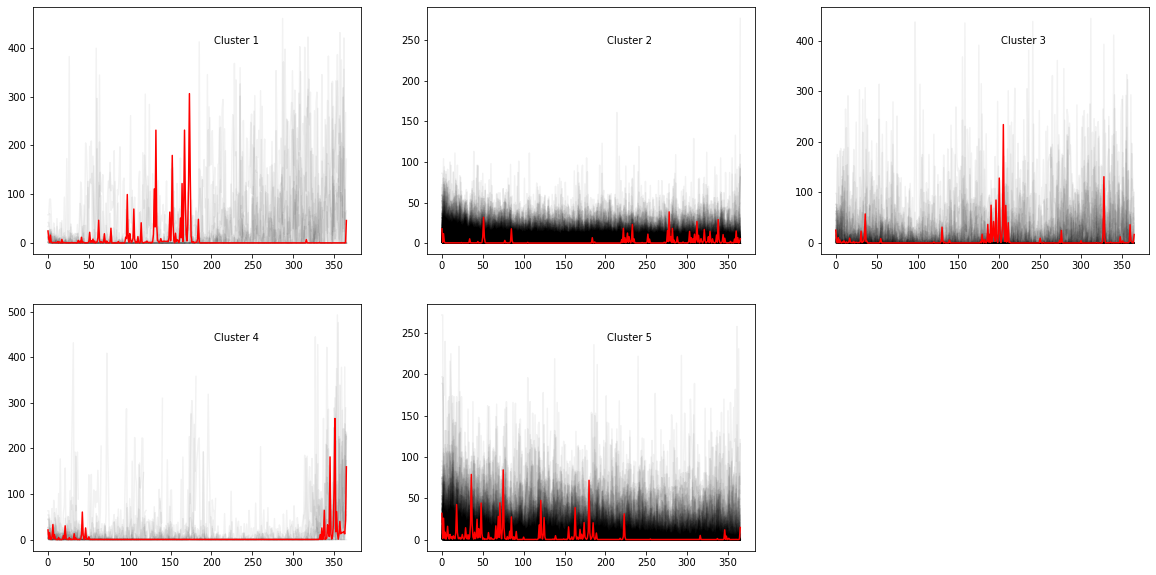

In [19]:
plt.figure(figsize=(20,10))

for yi in range(N):
    plt.subplot(2, 3, 1 + yi)
    for xx in formatted_time_series[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.05)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)

#plt.tight_layout()
plt.show()

In [23]:
def calculo_quant():
  soma = np.zeros(N)
  for i in range (N):
    for xx in formatted_time_series[y_pred == i]:
      soma[i] = soma[i] + 1
  return soma


In [32]:
quant = calculo_quant()

print('Porcentagem de alunos no Cluster 1: ', round(100*quant[0]/(sum(quant)),2),'%')
print('Porcentagem de alunos no Cluster 2: ', round(100*quant[1]/(sum(quant)),2),'%')
print('Porcentagem de alunos no Cluster 3: ', round(100*quant[2]/(sum(quant)),2),'%')
print('Porcentagem de alunos no Cluster 4: ', round(100*quant[3]/(sum(quant)),2),'%')
print('Porcentagem de alunos no Cluster 5: ', round(100*quant[4]/(sum(quant)),2),'%')

Porcentagem de alunos no Cluster 1:  2.4 %
Porcentagem de alunos no Cluster 2:  55.94 %
Porcentagem de alunos no Cluster 3:  9.06 %
Porcentagem de alunos no Cluster 4:  2.81 %
Porcentagem de alunos no Cluster 5:  29.79 %


In [33]:
from random import randrange

def plot_clusters(cluster):
  aleatorios = np.zeros(9)
  plt.figure(figsize=(20,10))
  for yi in range (9):
    while True:
      rand = randrange(len(formatted_time_series))

      if y_pred[rand] == cluster - 1 and (not(rand in aleatorios)):
        aleatorios[yi] = rand
        break
    plt.subplot(3, 3, 1 + yi)
    plot_dist_cluster(novo_intervalo[rand])
    plt.text(0.80, 0.85,'Example %d' % (yi + 1),
           transform=plt.gca().transAxes)

  plt.subplots_adjust(hspace=0.4, wspace=0.3)
  #plt.tight_layout()
  plt.show()

Distribuição diária de 9 Usuários aleatórios que foram classificados no cluster 1

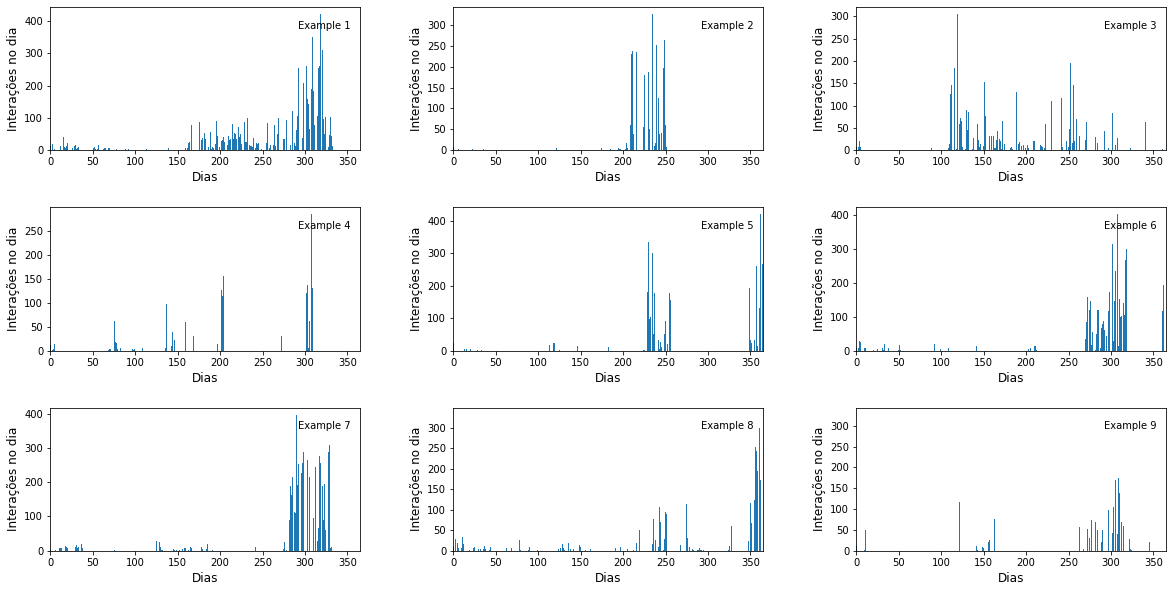

In [34]:
plot_clusters(1)

Distribuição diária de 9 Usuários aleatórios que foram classificados no cluster 2

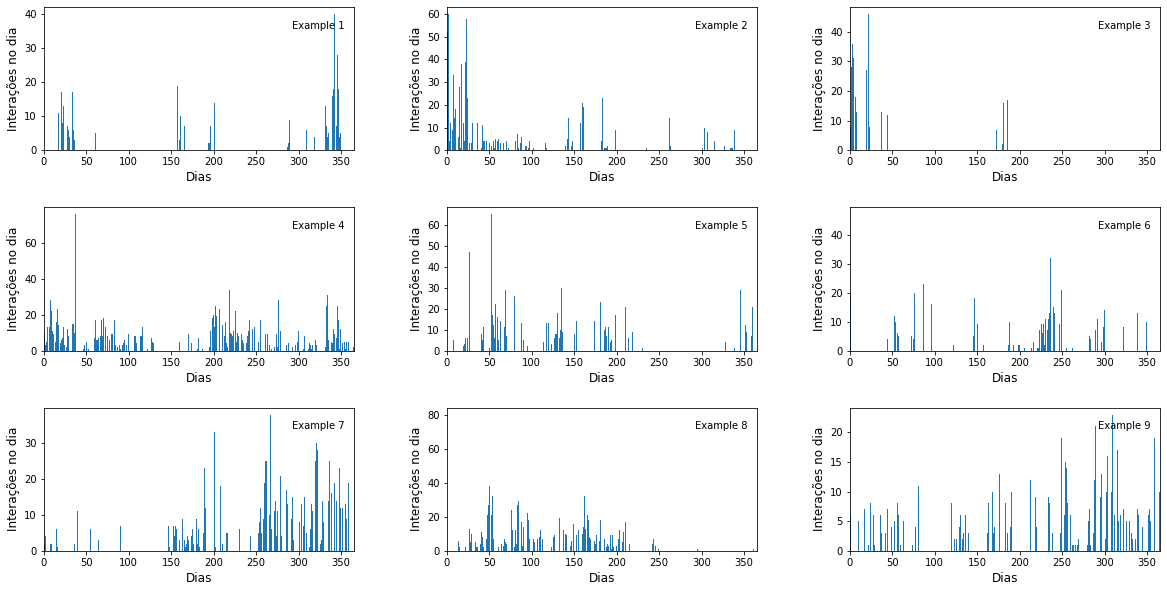

In [35]:
plot_clusters(2)

Distribuição diária de 9 Usuários aleatórios que foram classificados no cluster 3

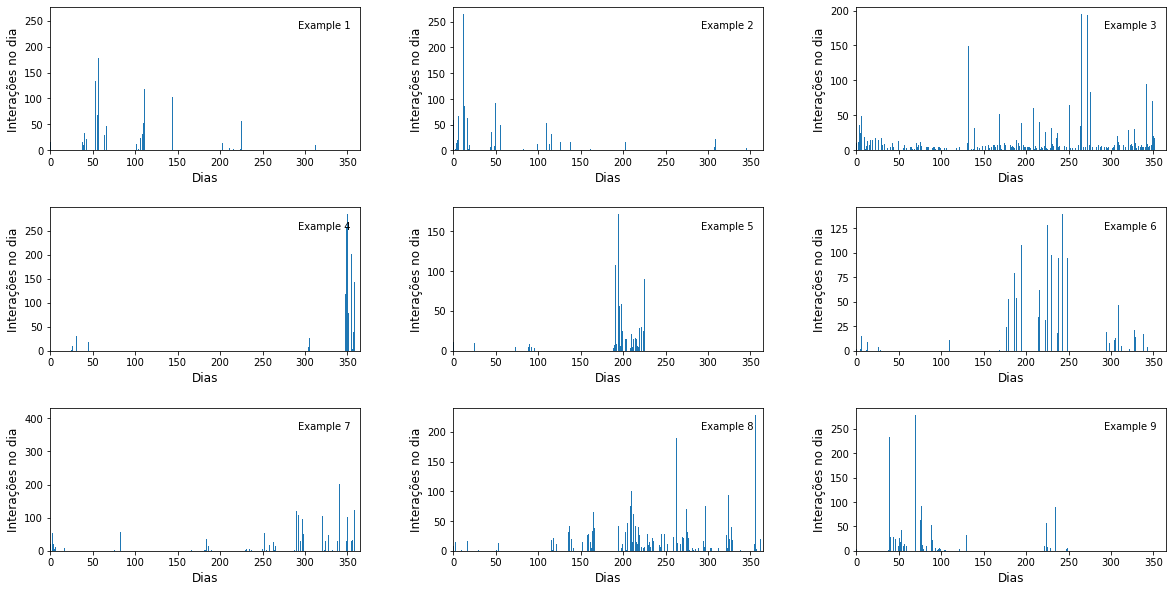

In [36]:
plot_clusters(3)

Distribuição diária de 9 Usuários aleatórios que foram classificados no cluster 4

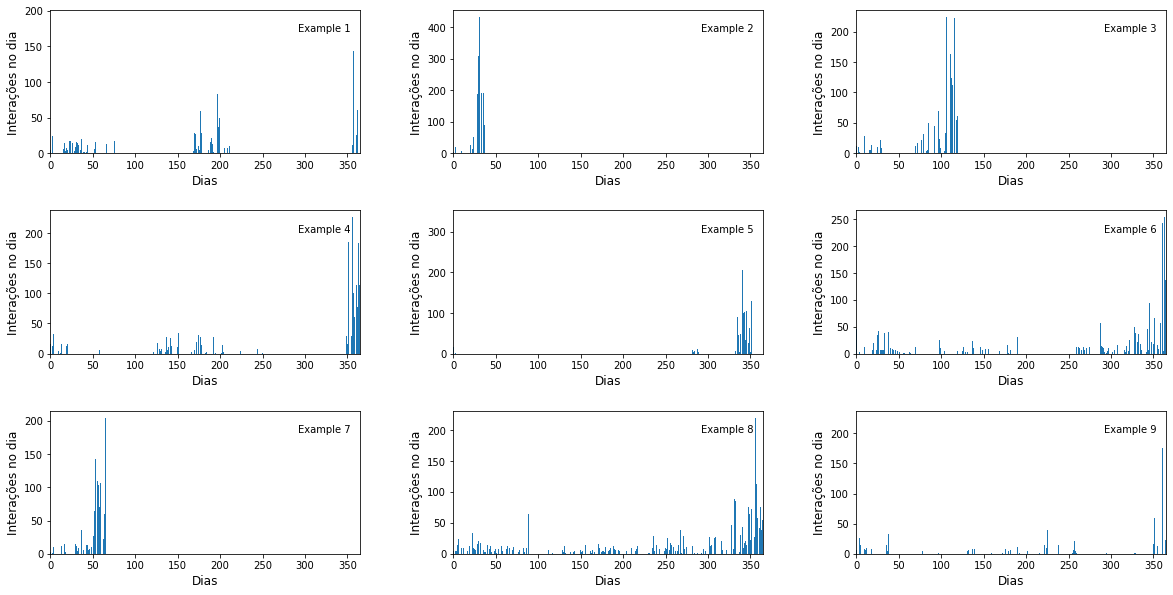

In [37]:
plot_clusters(4)

Distribuição diária de 9 Usuários aleatórios que foram classificados no cluster 5

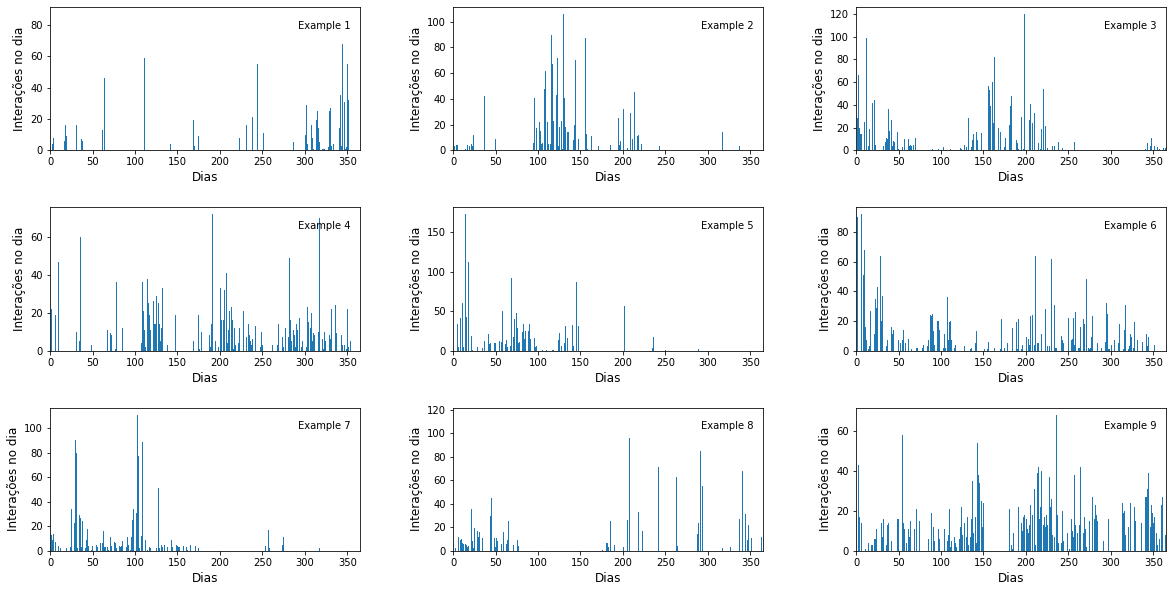

In [38]:
plot_clusters(5)

In [40]:
import h5py

sdtw_km.to_hdf5('/datalab/sdtw5.hdf5')